In [ ]:
from pettingzoo.classic import texas_holdem_v4
import copy
from agent_configs.cfr_config import CFRConfig
from active_player import ActivePlayer
from cfr_agent import CFRAgent
import torch
from cfr_network import CFRNetwork
game = texas_holdem_v4.env()

/Users/Ile-Maurice/Library/Python/3.10/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
hidden_dim = 128
input_dim = 72
output_dim = 4
num_players = 2
replay_buffer_size = 4000000
minibatch_size = 10000
steps_per_epoch = 3000
traversals = 3000
training_steps = 200
lr = 0.001
optimizer = None
p_v_networks = {'input_shape':input_dim, 'output_shape':output_dim, 'hidden_size':hidden_dim, 'learning_rate':lr, 'optimizer':optimizer}
active_player_obj = ActivePlayer(num_players)
config = CFRConfig(
    config_dict={'network': {'policy': p_v_networks, 'value': p_v_networks, 'num_players':num_players},
                 'replay_buffer_size':replay_buffer_size,
                 'minibatch_size':minibatch_size,
                 'steps_per_epoch':steps_per_epoch,
                 'traversals': traversals,
                 'training_steps': training_steps,
                 'active_player_obj': active_player_obj,
                 },
    game_config={'num_players':num_players,
                 'observation_space':72,
                 'action_space':4,},
)

CFRConfig


In [ ]:
sampling = ["MC", "Full"]
for sampling_method in sampling:
    game=texas_holdem_v4.env()
    model = CFRAgent(env=game,config=config, name="CFR_TXAS_HOLD_EM")
    model.train(sampling=sampling_method)


Iteration 0 done
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
Iteration 5 done
Iteration 6 done
Iteration 7 done
Iteration 8 done
Iteration 9 done
Iteration 10 done
Iteration 11 done
Iteration 12 done
Iteration 13 done
Iteration 14 done
Iteration 15 done
Iteration 16 done
Iteration 17 done
Iteration 18 done
Iteration 19 done
Iteration 20 done
Iteration 21 done
Iteration 22 done
Iteration 23 done
Iteration 24 done
Iteration 25 done
Iteration 26 done
Iteration 27 done
Iteration 28 done
Iteration 29 done
Iteration 30 done
Iteration 31 done
Iteration 32 done
Iteration 33 done
Iteration 34 done
Iteration 35 done
Iteration 36 done
Iteration 37 done
Iteration 38 done
Iteration 39 done
Iteration 40 done
Iteration 41 done
Iteration 42 done
Iteration 43 done
Iteration 44 done
Iteration 45 done
Iteration 46 done
Iteration 47 done
Iteration 48 done
Iteration 49 done
Iteration 50 done
Iteration 51 done
Iteration 52 done
Iteration 53 done
Iteration 54 done
Iteration 55 done
It

In [ ]:
agent1_state = torch.load('checkpoints/policy/linear/38063/1745086660.608601.pt')
agent2_state = torch.load('checkpoints/policy/linear/233694/1745086660.608601.pt')
agent3_state = torch.load('checkpoints/policy/notlinear/38063/1745086660.608601.pt')
agent4_state = torch.load('checkpoints/policy/notlinear/233694/1745086660.608601.pt')

agent1 = CFRNetwork(
     config = {'policy': p_v_networks, 'value': p_v_networks, 'num_players':num_players}
)
agent1.policy.load_state_dict(agent1_state)
agent2 = CFRNetwork(
     config = {'policy': p_v_networks, 'value': p_v_networks, 'num_players':num_players}
)
agent2.policy.load_state_dict(agent2_state)
agent3 = CFRNetwork(
     config = {'policy': p_v_networks, 'value': p_v_networks, 'num_players':num_players}
)
agent3.policy.load_state_dict(agent3_state)
agent4 = CFRNetwork(
     config = {'policy': p_v_networks, 'value': p_v_networks, 'num_players':num_players}
)
agent4.policy.load_state_dict(agent4_state)


In [ ]:
agent1.policy.eval()
agent2.policy.eval()
agent3.policy.eval()
agent4.policy.eval()

In [ ]:
agents = [agent1, agent2, agent3, agent4]

In [ ]:
def evaluatebots(agent1, agent2, num_of_eval_games):
    modelselect = CFRAgent(env=game, config=config)
    eval_games = num_of_eval_games
    import numpy as np
    rewards_player_1 = []
    rewards_player_2  = []
    for i in range(eval_games):
        # FOR EACH EVAL GAME, RESET ENVIRONEMENT (DEBATABLE STEP) BUT RESET WITH SET SEED FOR RECREATION
        random_seed = np.random.randint(0, 2**32 - 1)
        observation, reward, termination, truncation, infos =  modelselect.env.last()

        modelselect.env.reset(seed=random_seed)
        active_player =  modelselect.env.agent_selection[-1]
        modelselect.active_player_obj.set_active_player(int(active_player))
        while not termination and not truncation:
            # GET CURRENT STATE
            observation, reward, termination, truncation, infos =  modelselect.env.last()
            if termination or truncation:
                break
            active_player =  modelselect.active_player_obj.get_active_player()
            if active_player == 0:
                predictions = agent1.policy(torch.tensor(observation['observation'], dtype=torch.float32).reshape(1,36)).detach().numpy()[0]

                sample, policy = modelselect.select_actions(predictions, info=torch.from_numpy(observation["action_mask"]).type(torch.float), mask_actions=True)
            else:
                # predictions = np.ones(4) / 4
                # sample, policy = modelselect.select_actions(predictions, info=torch.from_numpy(observation["action_mask"]).type(torch.float), mask_actions=True)
                predictions = agent2.policy(torch.tensor(observation['observation'], dtype=torch.float32).reshape(1,36)).detach().numpy()[0]
                sample, policy = modelselect.select_actions(predictions, info=torch.from_numpy(observation["action_mask"]).type(torch.float), mask_actions=True)
            # if active player, branch off and traverse
            modelselect.env.step(sample)
            modelselect.active_player_obj.next()
        final_rewards_p_1 = modelselect.env.rewards["player_0"]  # dict of {agent_0: r0, agent_1: r1}
        final_rewards_p_2 = modelselect.env.rewards["player_1"]
        rewards_player_1.append(final_rewards_p_1)
        rewards_player_2.append(final_rewards_p_2)
        modelselect.env.close()
    return rewards_player_1, rewards_player_2
    print("PLAYER 1 REW MEAN: ", np.mean(rewards_player_1))
    print("PLAYER 1 REW STD: ", np.std(rewards_player_1))
    print("PLAYER 2 REW MEAN: ", np.mean(rewards_player_2))
    print("PLAYER 2 REW STD: ", np.std(rewards_player_2))

In [16]:
import numpy as np
results = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        rewards_player_1, rewards_player_2 = evaluatebots(agents[i], agents[j], 100000)
        results[i][j] = np.mean(rewards_player_1)

print("RESULTS: ")
# print results as matplotlib matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=["agent1", "agent2", "agent3", "agent4"], yticklabels=["agent1", "agent2", "agent3", "agent4"])
plt.title("Results")
plt.xlabel("Agent 2")
plt.ylabel("Agent 1")
plt.show()

RESULTS: 


/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_11419/990800509.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [17]:
# save results to file
import pandas as pd
df = pd.DataFrame(results, columns=["agent1", "agent2", "agent3", "agent4"], index=["agent1", "agent2", "agent3", "agent4"])
df.to_csv("results.csv", index=True)

          agent1    agent2    agent3    agent4
agent1 -0.007740  0.171425 -0.036095  0.095275
agent2 -0.167325 -0.000340 -0.201130 -0.058665
agent3  0.056730  0.193530 -0.005345  0.129050
agent4 -0.103055  0.063135 -0.131195  0.011005


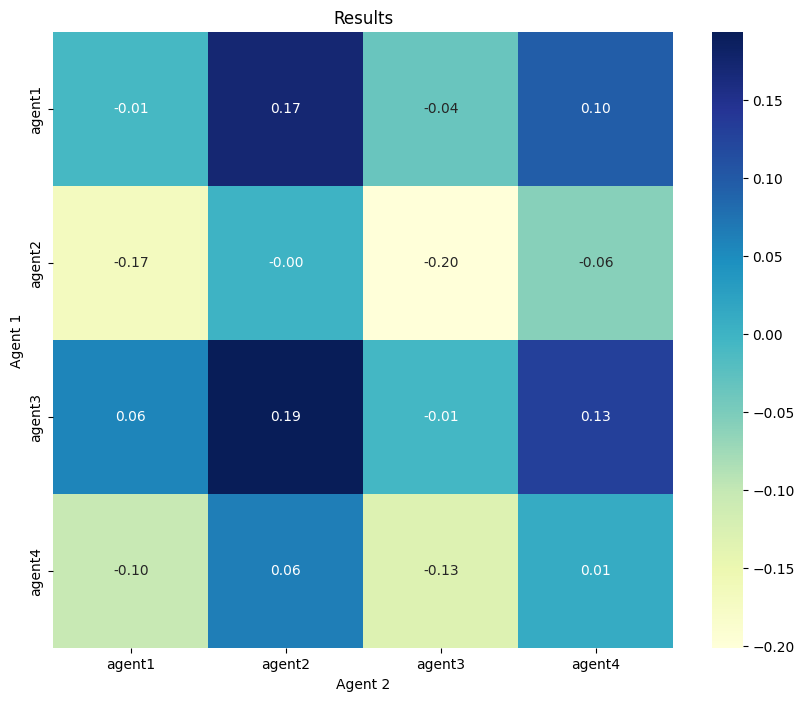

In [3]:
# load results from file
import pandas as pd
df = pd.read_csv("results.csv", index_col=0)
print(df)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=["agent1", "agent2", "agent3", "agent4"], yticklabels=["agent1", "agent2", "agent3", "agent4"])
plt.title("Results")
plt.xlabel("Agent 2")
plt.ylabel("Agent 1")
plt.show()